# Logistic Regression for Injury Risk Data

The most common method for modeling the probability of injury given crash characteristics is logistic regression. This notebook fits a logistic regression using `sklearn`.

In [1]:
import copy
import numpy as np
import sklearn.linear_model
import sklearn.metrics
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

## Data

The dataset used was from real-world traffic crashes (NASS/CDS) from [this paper (Kusano and Gabler 2014)](https://doi.org/10.1080/15389588.2014.927577). The dataset contains information from vehicles involved in real-world crashes with corresponding crash investigations.  The following table describes the variables of interest. All variables except `log_deltaV` are categorical.

| Variable            | Description                                              |
|---------------------|----------------------------------------------------------|
| log_deltaV          | Logarithm of change in velocity of crash (mph)           |
| GAD                 | General area of damage (1=Front, 2=Right, 3=Left, 4=Back)|
| all_belted          | Driver and right front passenger were belted (1=Yes, 0=No)|
| body_type           | Vehicle type (1=Car, 2=SUV, 3=Van, 4=Pickup)             |
| multiple_events     | Vehicle experience more than 1 crash (1=Yes, 0=No)       |
| veh55_or_older      | At least one occupant is 55 years or older (1=Yes, 0=No) |
| veh_all_male        | All occupants are male (1=Yes, 0=No)                     |

The variable `vehicle_iss15` is a binary variable describing if there is serious injury to occupants in the event of a crash (1=injury, 0=no injury).

Case years 2010 and 2011 (the last 2 years) of the data were used to reduce the variability due to changes in the vehicle fleet.

In [2]:
df = pd.read_csv('AACN_dataset.csv')
df = df.loc[df['caseyear'].isin([2011, 2010]), :]
x_vars = ['log_deltaV', 'GAD', 'all_belted', 'body_type', 'multiple_events', 'veh55_or_older', 'veh_all_male']
y_var = 'vehicle_iss15'
weight_var = 'ratwgt'

## Model training

The data was split into a training and testing sample. The training sample was used to fit the model and the testing sample was used to evaluate the performance of the model. If the same data are used to both fit and evaluate the model, the best performing model may overfit the data. Given new (and slight different) future data, overfit models usually underperform non-overfit models. This test/train splitting approach is commonly used to avoid overfitting. Because NASS/CDS has a complex survey design, each row has an associated weight that corresponds to the number of similar crashes that occurred throughout the U.S. These weights are used in both model fitting and evaluation.

In [3]:
X_train, X_test, Y_train, Y_test = train_test_split(df.loc[:, x_vars + [weight_var]], df[y_var], test_size=0.2, random_state=3091)
W_train = X_train.pop(weight_var)
W_test = X_test.pop(weight_var)

### Model with default parameters
 
First, we fit a model using the default parameters. 

As an aside, you may wonder why a `deepcopy` of the weight vector is required. In doing this analysis I discovered a [bug](https://github.com/scikit-learn/scikit-learn/issues/18347) in `sklearn` where the fitting function is modifying the `sample_weight` argument. Because python passes complex objects by reference, that means the variable `W_train` would change after model fitting, causing future model fits to be incorrect.

In [4]:
classifier = sklearn.linear_model.LogisticRegression(random_state=3091)
classifier = classifier.fit(copy.deepcopy(X_train), copy.deepcopy(Y_train), sample_weight=copy.deepcopy(W_train))


Below we visualize the injury risk prediction as an example of how these models work. The plot below shows the probability of injury in a frontal collision involving a car with a single event, not all occupants are over 55 years old, and not all the occupants are male. The horizontal axis shows the change in velocity (delta-V) during the collision in miles per hour. The blue curve shows the risk if all occupants are belted and the red curve shows the risk if not all occupants are belted. The points plotted at 0 and 1 are the training data points. As is expected, the risk of injury is greater when some occupants are not wearing a seatbelt. The predicted injury risk, however, is very low for both belted and unbelted vehicles only coming towards 50% (the threshold for a probabilistic classifier) at very high delat-V's not seen in the data.

Text(0, 0.5, 'Porbability of ISS15+ Vehicle')

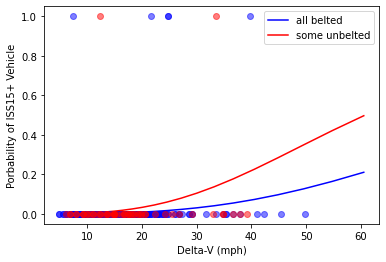

In [5]:
delta_v_plot = np.arange(np.log(10), np.log(65), 0.1)
x_belted = [1, 1, 1, 0, 0, 0]
x_unbelted = copy.deepcopy(x_belted)
x_unbelted[1] = 0

x_b = [[dv] + x_belted for dv in delta_v_plot]
x_ub = [[dv] + x_unbelted for dv in delta_v_plot]
y_b = classifier.predict_proba(x_b)
y_ub = classifier.predict_proba(x_ub)

plt.plot(np.exp(delta_v_plot), y_b[:, 1], '-b', label='all belted')
plt.plot(np.exp(delta_v_plot), y_ub[:, 1], '-r', label='some unbelted')
plt.legend()

idx_b = np.ones(len(X_train)).astype(bool)
for i, x_lev in enumerate(x_belted):
    idx_b &= (X_train[x_vars[i + 1]] == x_lev)

idx_ub = np.ones(len(X_train)).astype(bool)
for i, x_lev in enumerate(x_unbelted):
    idx_ub &= (X_train[x_vars[i + 1]] == x_lev)

plt.plot(np.exp(X_train.loc[idx_b, 'log_deltaV']), Y_train.loc[idx_b], 'ob', alpha=0.5)
plt.plot(np.exp(X_train.loc[idx_ub, 'log_deltaV']), Y_train.loc[idx_ub], 'or', alpha=0.5)
plt.xlabel('Delta-V (mph)')
plt.ylabel('Porbability of ISS15+ Vehicle')

To evaluate the model's accuracy, here we are using an [F1 score](https://en.wikipedia.org/wiki/F1_score). The F1 score is a combination of the precision and recall. A perfect predictor will have a F1 score of 1.0 and a classifier that either has zero precision or recall will have an F1 score of 0.0. 

$$$
F_1 = 2 \cdot \frac{Precision \cdot Recall}{Precision + Recall}
$$$

This type of scoring has an advantage over traditional "accuracy" especially for imbalanced data where one class (injury) is much less common than the other (no injury). In the imbalanced case, the model with the highest accuracy might be one that never predicts injury.

$$$
Accuracy = \frac{\Sigma True Positive + \Sigma True Negative}{n}
$$$

The default parameters yield an F1 score of 0, which indicates this is a bad classifier.

In [6]:

y_pred = classifier.predict(X_test)
f1 = sklearn.metrics.f1_score(Y_test, y_pred, sample_weight=W_test)
print('F1 score for default class weighting: {:.5f}'.format(f1))

F1 score for default class weighting: 0.00000


Below is the confusion matrix for the default classifier, normalized by the population (all cells add to 1.0). This classifier never predicts an injury, therefore the precision is 0.0, which makes the F1 score also zero. We should look at adjusting the model parameters to resolve this issue.

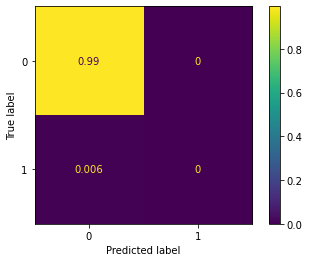

In [7]:
sklearn.metrics.plot_confusion_matrix(classifier, X_test, Y_test, sample_weight=W_test, normalize='all')

### Model with class weights

The model fitting is an optimization problem that penalizes incorrect model classification. By default, the fitting method penalizes incorrect class predictions proportional to the occurrence of the classes. In our case, the data are extremely unbalanced with only 6.4% of the cases and 1.3% of the cases by weight having an injury. In this case, we need to penalize an incorrect prediction in the injury case more than a incorrect prediction in the no injury case. We can accomplish this by adjusting the `case_weights` argument. Other ways to account for this imbalance are over/under sampling methods. The weighted nature of this data makes sampling methods a little more complicated, so I favored the case weight adjustment because it is a single nob to adjust.

In [8]:
print('Weighted proportion')
print(df.groupby(y_var)[weight_var].sum() / df[weight_var].sum())
print('\nUnweighted proportions')
print(df.groupby(y_var).size() / len(df))

Weighted proportion
vehicle_iss15
0    0.986321
1    0.013679
Name: ratwgt, dtype: float64

Unweighted proportions
vehicle_iss15
0    0.935501
1    0.064499
dtype: float64


Because the `case_weight` is a model parameter, here I fit many different models to find an optimum value. I adjusted the case_weight proportion and measured the model fit by F1 score as before. The result is a class weight of 1.0 to 5.15 has the highest F1 score.

Class weight: 5.15 has max f1 score: 0.1213


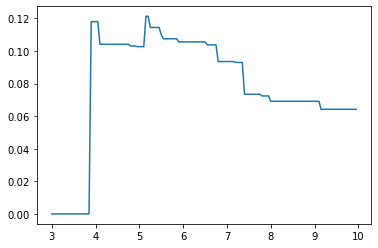

In [9]:
class_weights = np.arange(3, 10, 0.05)
f1_scores = []
weight_max = float('nan')
f1_max = 0
for class_weight in class_weights:
    classifier = sklearn.linear_model.LogisticRegression(solver='lbfgs', class_weight={0: 1.0, 1: class_weight}, random_state=0)
    classifier.fit(copy.deepcopy(X_train), copy.deepcopy(Y_train), sample_weight=copy.deepcopy(W_train))

    y_pred = classifier.predict(X_test)
    f1 = sklearn.metrics.f1_score(Y_test, y_pred, sample_weight=W_test)
    f1_scores.append(f1)

    if f1 > f1_max:
        f1_max = f1
        weight_max = class_weight
        max_classifier = copy.deepcopy(classifier)

plt.plot(class_weights, f1_scores)
print('Class weight: {:.2f} has max f1 score: {:.4f}'.format(weight_max, f1_max))

With this better tuned model, we can see that positive predictions are now made. However, the number of false positives are an order of magnitude larger than the number of true positives and there are more false negatives than true positives. This result still suggestions this classifier is not so useful in predicting future outcomes.

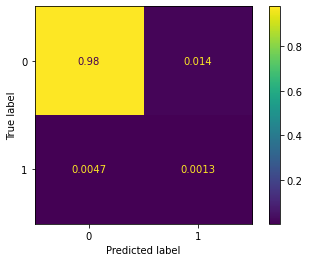

In [10]:
sklearn.metrics.plot_confusion_matrix(max_classifier, X_test, Y_test, sample_weight=W_test, normalize='all')